In [1]:
import dataloader
import pandas as pd
import utils
from model import generate_model
import os
import torch
import torch.nn as nn

from optimizer import Adam,SGD

from train_wrapper import train_epoch
import datetime
import numpy as np

In [2]:
config = utils.load_config()

batch_size = config['dataloader']['batch_size']
num_workers = config['dataloader']['num_workers']
pin_memory = config['dataloader']['pin_memory'] == 1 
gpu_parallel = config['gpus']
learning_rate = config['train']['learning_rate']
lr_steps = config['train']['lr_steps']
epochs = config['train']['epochs']

config['save_datetime'] = datetime.datetime.now().strftime("%Y%m%d_%H%M")


In [3]:
#데이터셋 분리(Train, validation, test)
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna().reset_index(drop=True)
df_oasis = df_dataset[df_dataset['source'] == 'OASIS-3']
df_adni = df_dataset[df_dataset['source'] == 'ADNI']

In [4]:
#데이터 분포도 확인 
data_summary=''
raw_ad,raw_cn,raw_mci = pd.get_dummies(df_dataset['group_maxinc']).sum()

raw_total = raw_ad + raw_cn + raw_mci
data_summary = 'Raw Data\n Total: {}    CN : {} ({:.2f}% of total),   MCI: {} ({:.2f}% of total),   AD : {} ({:.2f}% of total)'.format(raw_total, raw_cn,  100 * raw_cn / raw_total, raw_mci, 100 * raw_mci / raw_total, raw_ad,  100 * raw_ad / raw_total)

oasis_ad,oasis_cn,oasis_mci = pd.get_dummies(df_oasis['group_maxinc']).sum()

oasis_total = oasis_ad + oasis_cn + oasis_mci
data_summary += '\nOasis Data\n Total: {}    CN : {} ({:.2f}% of total),   MCI: {} ({:.2f}% of total),   AD : {} ({:.2f}% of total)'.format(oasis_total, oasis_cn,  100 * oasis_cn / oasis_total, oasis_mci, 100 * oasis_mci / oasis_total, oasis_ad,  100 * oasis_ad / oasis_total)

adni_ad,adni_cn,adni_mci = pd.get_dummies(df_adni['group_maxinc']).sum()
adni_total = adni_ad + adni_cn + adni_mci
data_summary += '\nADNI Data\n Total: {}    CN : {} ({:.2f}% of total),   MCI: {} ({:.2f}% of total),   AD : {} ({:.2f}% of total)'.format(adni_total, adni_cn,  100 * adni_cn / adni_total, adni_mci, 100 * adni_mci / adni_total, adni_ad,  100 * adni_ad / adni_total)

print(data_summary)

Raw Data
 Total: 990    CN : 576 (58.18% of total),   MCI: 263 (26.57% of total),   AD : 151 (15.25% of total)
Oasis Data
 Total: 824    CN : 524 (63.59% of total),   MCI: 183 (22.21% of total),   AD : 117 (14.20% of total)
ADNI Data
 Total: 166    CN : 52 (31.33% of total),   MCI: 80 (48.19% of total),   AD : 34 (20.48% of total)


In [5]:
X_train,X_val,y_train,y_val = dataloader.dataset_split(df_oasis,test_size=0.2,shuffle=True,grp=None,seed=1004)
X_test = df_adni.drop(labels='group_maxinc',axis=1)
y_test = df_adni['group_maxinc']

d:\MyGit\BrainMR_MCI\dataloader.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['grp'] = (df_dataset['source'].str.replace('OASIS-3','1').str.replace('ADNI','2').apply(pd.to_numeric)*1000


In [6]:
import torchio as tio
from torch.utils.data import DataLoader,ConcatDataset,WeightedRandomSampler

# class 0 : 43200개, class 1 : 4800개
class_counts = y_train.value_counts().to_dict() #43200, 4800
num_samples = sum(class_counts.values()) # 48000 - 전체 데이터 갯수
labels = y_train.to_list()

#클래스별 가중치 부여 [48000/43200, 48000/4800] => class 1에 가중치 높게 부여하게 됨
class_weights = {i:num_samples / class_counts[i] for i in class_counts.keys()}

# 해당 데이터의 label에 해당되는 가중치
weights = [class_weights[labels[i]] for i in range(int(num_samples))] #해당 레이블마다의 가중치 비율

sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

transform = tio.RandomAffine(degrees=(0,0,90)) #이미지 좌우로 랜덤 생성

traindata=dataloader.MRIDataset(X_train,y_train)
#aug_traindata=dataloader.MRIDataset(X_train,y_train,transform)

#train_plus = ConcatDataset([traindata, aug_traindata])

valdata=dataloader.MRIDataset(X_val,y_val)
testdata=dataloader.MRIDataset(X_test,y_test)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(traindata , batch_size=batch_size, shuffle=False, sampler = sampler
                              ,num_workers=num_workers,pin_memory = pin_memory)
val_dataloader  = DataLoader(valdata, batch_size=batch_size, shuffle=False
                              ,num_workers=num_workers,pin_memory = pin_memory)
test_dataloader  = DataLoader(testdata, batch_size=1, shuffle=False)

print('train_dataloader : ',len(train_dataloader.dataset))
print('val_dataloader : ',len(val_dataloader.dataset))
print('test_dataloader : ',len(test_dataloader.dataset))

train_dataloader :  659
val_dataloader :  165
test_dataloader :  166


age  tensor(0.5600) labels:  tensor(0)
image shape torch.Size([1, 128, 128, 128])
max value tensor(1.)
min value tensor(0.)


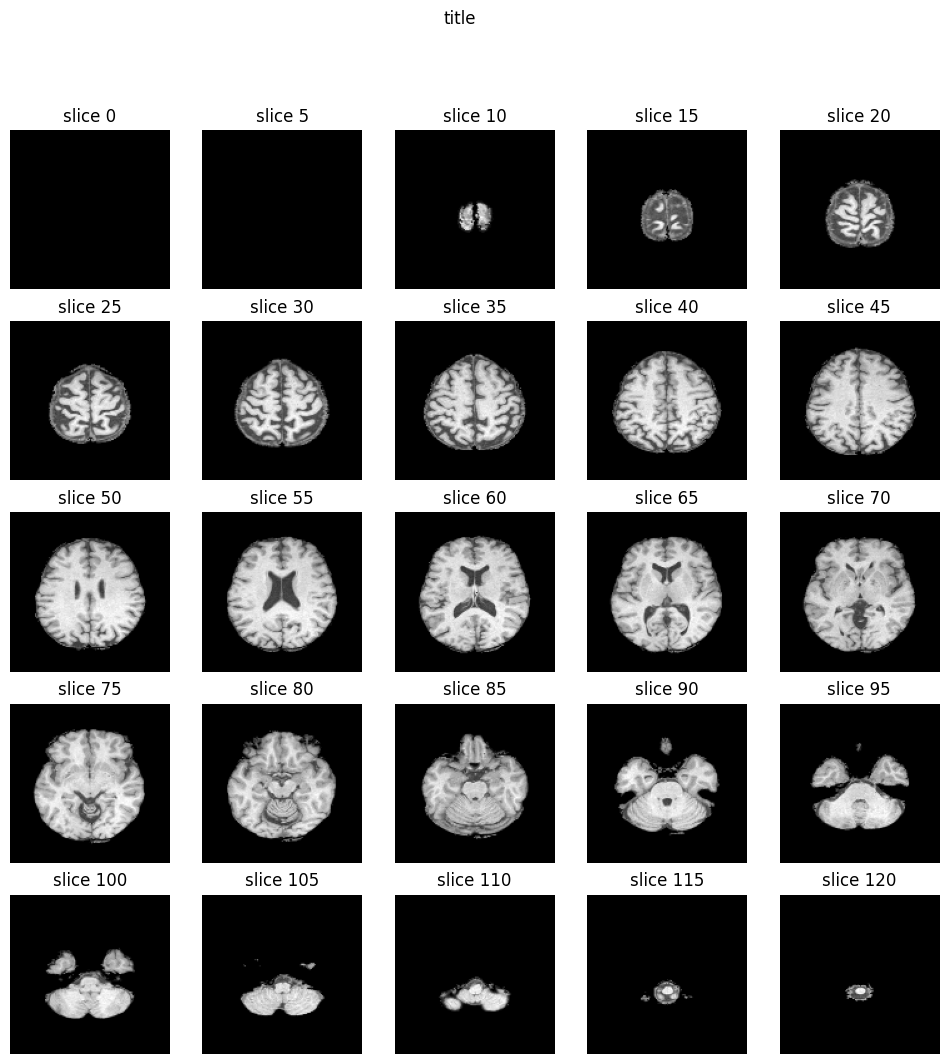

In [7]:

image,age,labels = train_dataloader.dataset.__getitem__(600)
print('age ',age.data,'labels: ',labels)
print('image shape',image.shape)
print('max value',image[0,:,:,:].max())
print('min value',image[0,:,:,:].min())
utils.stack_plot(image[0,:,:,:],rows=5,cols=5,start_with=0,show_every=5)

age  tensor(0.8300) labels:  tensor(2)
image shape torch.Size([1, 128, 128, 128])
max value tensor(1.)
min value tensor(0.)


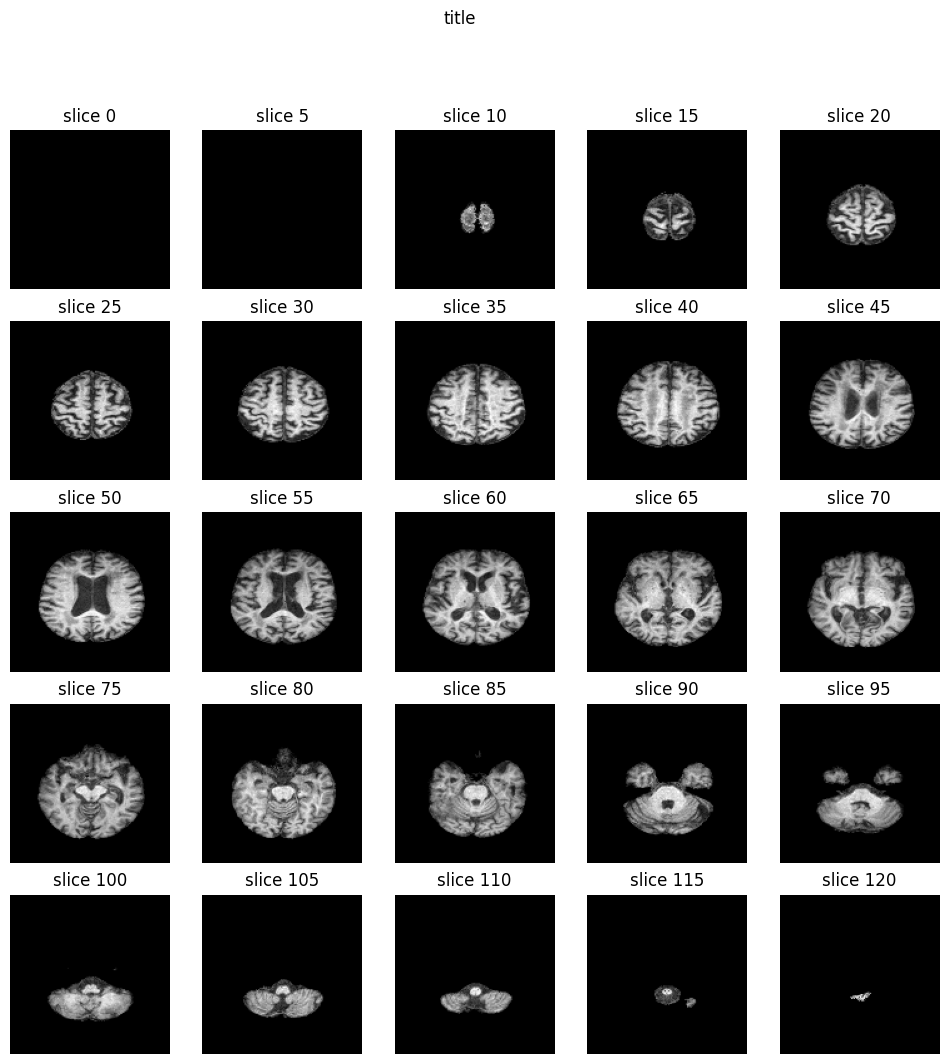

In [8]:

image,age,labels = train_dataloader.dataset.__getitem__(100)
print('age ',age.data,'labels: ',labels)
print('image shape',image.shape)
print('max value',image[0,:,:,:].max())
print('min value',image[0,:,:,:].min())
utils.stack_plot(image[0,:,:,:],rows=5,cols=5,start_with=0,show_every=5)